In [1]:
import stt
import spliter
import compressor
import json

import vad_test as vt
import librosa
import copy

import numpy as np
import matplotlib.pyplot as plt
from vad_test import play
import IPython.display as display

no env is setup, using dev env default


In [114]:
video_file = './80_resized_powercast1.mp4'

In [3]:
# video_file = './46.mp4'
language = "ko"
video_meta = {}
video_meta['Hz'] = 44100
compressed_video_file, video_meta = compressor.compress(video_file)
res = stt.stt(compressed_video_file, language, video_meta)

ffmpeg -y -i ./80_resized_powercast1.mp4 -filter:v scale="640:ih*640/iw" -c:a copy /tmp/resized_80_resized_powercast1.mp4
resized_80_resized_powercast1.flac
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
89


KeyboardInterrupt: 

In [137]:
# wave, fs = librosa.load(video_file)
# fe = vt.FeatureExtraction(wave, fs)
fe.get_wave_point(cut_eh=0.97, cut_n=0.95)
hangover = fe.check_speech(fe.vad_value, frameoffset=6)
daf = fe.denoise_after_vad(hangover)
bridge = fe.make_bridge(daf, step=25)
hangover2 = fe.check_speech(bridge, frameoffset=4)

Extracting Harmonics...


/home/jm2338/Work/script_voithru/jamake-engine/vad_test.py:162: ComplexWarning: Casting complex values to real discards the imaginary part
  blank_array[i] = self._get_column_harmonic(hpeak[:,i])


Wave smoothing...
~Smooth~
\Harmonics/
Extracting Entropy...


/home/jm2338/Work/script_voithru/jamake-engine/vad_test.py:43: RuntimeWarning: invalid value encountered in true_divide
  div_square_abs_stft = square_abs_stft / np.sum(square_abs_stft, axis=0)


\Entropy/
Extract SEM...


/home/jm2338/Work/script_voithru/jamake-engine/vad_test.py:337: RuntimeWarning: divide by zero encountered in true_divide
  norm_eh = self.normalization(smhar/sment)


Wave smoothing...
~Smooth~
Wave smoothing...
~Smooth~
\SEM/


/home/jm2338/Work/script_voithru/jamake-engine/vad_test.py:242: RuntimeWarning: divide by zero encountered in true_divide
  psr = (B - pmin)/mu
/home/jm2338/Work/script_voithru/jamake-engine/vad_test.py:242: RuntimeWarning: invalid value encountered in true_divide
  psr = (B - pmin)/mu


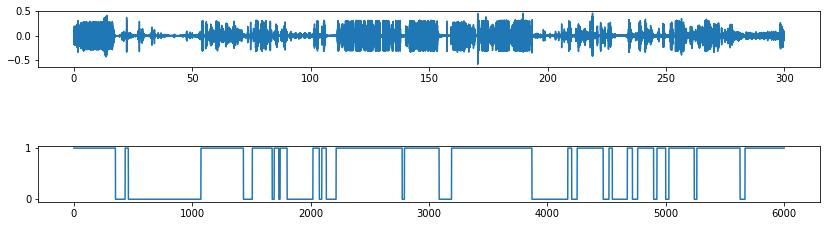

In [94]:
'''
test: vad wave check
'''
start = 0
end = 6000
t = np.linspace(0, len(fe.wave)/fe.fs, num = len(fe.wave))
plt.figure(figsize=(14, 6))
# plt.subplot(511)
# plt.plot(hangover[start:end])
# plt.subplot(512)
# plt.plot(daf[start:end])
plt.subplot(513)
plt.plot(t[start*fe.frame_shift:end*fe.frame_shift], (wave)[start*fe.frame_shift:end*fe.frame_shift])
# plt.axvline(x=0.05, color='r')
# plt.axvline(x=0.5, color='r')
# plt.subplot(514)
# plt.plot(bridge[start:end])
plt.subplot(515)
plt.plot(hangover2[start:end])
# play((fe.wave)[start*fe.frame_shift:end*fe.frame_shift], fe.fs)

In [135]:
def find_zero_section_frame(vad_result, find_speech=0):
    '''
    nonspeech 구간을 프레임의 튜플들의 리스트로 리턴하는 함수
    find_speech: 0 or 1
    0이면 nonspeech 찾기
    1이면 speech 찾기찾
    '''
    start_frame = 0
    end_frame = 0
    zero_section_lst = []
    zero_section = ()
    
    if find_speech == 0: # want to find non-speech
        zero_elms = np.where(vad_result == 0)[0]
    else: # want to find speech
        zero_elms = np.where(vad_result == 1)[0]
        
        
    if len(zero_elms)==0:
        return None
    if len(zero_elms)==1 and zero_elms[0]==0:
        return None
#     if zero_elms[0]==0:
#         zero_elms.pop(0)

    for num, zero_idx in enumerate(zero_elms):
        if num==0:
            start_frame = zero_elms[num]
            end_frame = zero_elms[num]
            if zero_idx == zero_elms[-1]:
                zero_section = (start_frame, end_frame)
                zero_section_lst.append(zero_section)
                return zero_section_lst
            else:
                continue
        else:
            if zero_elms[num-1]+1 == zero_idx: # 앞의 zero_idx와 이어진다면
                end_frame = zero_idx
                
                if zero_idx == zero_elms[-1]:
                    zero_section = (start_frame, end_frame)
                    zero_section_lst.append(zero_section)
                    return zero_section_lst
                
                else:
                    continue
                    
            else: # 이어지지 않으면 리스트에 기존 섹션 넣고 새로운 섹션 시작
                zero_section = (start_frame, end_frame)
                zero_section_lst.append(zero_section)
                start_frame = zero_idx
                end_frame = zero_idx
                
                if zero_idx == zero_elms[-1]:
                    zero_section = (start_frame, end_frame)
                    zero_section_lst.append(zero_section)
                    return zero_section_lst
                else:
                    continue        
        
def zero_section_frame_to_sec(zero_section_frame, fs, frame_shift):
    '''
    find_zero_section_frame의 리턴값을 받아서
    sec단위로 반환하는 함수
    '''
    sec_lst = np.asarray(zero_section_frame, dtype=float)
    if len(zero_section_frame)==0:
        return sec_lst
    for i in sec_lst:
        i[0] = round(i[0]/fs*frame_shift, 2)
        i[1] = round((i[1]+1)/fs*(frame_shift),2)
    return sec_lst

In [136]:
def elm_to_float(elm):
    '''string으로 되어있는 startTime, endTime을 float로 만들어주는 함수'''
    startTime = float(elm['startTime'].replace('s',''))
    endTime = float(elm['endTime'].replace('s',''))
    return startTime, endTime

def check_end_location_to_split(words_lst, nonspeech_sec):
    words_lst_copy = copy.deepcopy(words_lst)
    split_location = []
    idx_flag = -1
    for nons in nonspeech_sec:
        '''
        nons = [22.94, 23.84]
        '''
        start_buffer = []
        end_buffer = []
        
        for idx, elm in enumerate(words_lst_copy):
            '''
            elm = {'startTime': '1.29s', 'endTime': '1.300s', 'word': '입금은'}
            '''
            startTime, endTime = elm_to_float(elm)
            
            if (nons[0] - endTime <= 3) and (nons[0] >= endTime): # Nstart가 endTime보다 크고 둘의 차이가 2초 이내일 때
                start_buffer.append((idx, elm, nons))
                if idx+1==len(words_lst_copy):
                    try:
                        split_location.append(start_buffer[-1])
                    except:
                        break
            
            elif (endTime > nons[0]) or idx+1==len(words_lst_copy): # endTime이 Nstart보다 클 때는 for문을 멈추고 startbuffer 완성한다.
                try:
                    split_location.append(start_buffer[-1])
                    break
                except: # start_buffer가 None일 때
                    break
            
            else: # 2초 이내가 아직 아닐 때
                continue
                
    return split_location

def fix_endpoint(words_lst, end_location_to_split):
    words_lst_copy = copy.deepcopy(words_lst)
    
    for i in end_location_to_split:
        # start 수정하기
        words_lst_copy[i[0]]['endTime'] = str(i[2][0]) + "s"
        # 수정된 elm 뒤로 수정할 엘리먼트 버퍼에 넣기
        idx = i[0] + 1
        while idx < len(words_lst):
            startTime, endTime = elm_to_float(words_lst_copy[idx])
            if startTime < i[2][1]: # Nend보다 startTime이 앞이라면
                words_lst_copy[idx]['startTime'] = str(i[2][1]) + "s"
                if endTime < i[2][1]:
                    words_lst_copy[idx]['endTime'] =str(i[2][1]) + "s"
                    idx += 1
                else:
                    idx += 1
                    continue
            else:
                break
    return words_lst_copy

'''
nonspeech+speech 구간 같이 띄우기
'''
def play_test(speech_section_sec, wave=wave, fs=fs):
    '''ex. 
    plot_test(speech_sec_lst)'''
    for idx,i in enumerate(speech_section_sec):
        display.display(display.Audio(data=wave[int(i[0]*fs):int(i[1]*fs)], rate=fs))
        print(i)
#         plt.subplot(speech_section_sec.shape[0], 1, idx)
        plt.plot(wave[int(i[0]*fs):int(i[1]*fs)])

In [146]:
def joint_words(words):
    """
    words: word 단위 [start, end, word] 리스트
    """
    sentences = []
    sentence = {}
    # for idx, elm in enumerate(words):
    i = 0
    joint = []
    some_words = []
    while i < len(words):    
        if i == 0:
            if i!= len(words)-1:
                sentence['startTime']=words[i]['startTime']
                some_words.append(words[i])
                joint.append(words[i]['word'])
                i+=1
            else:
                sentences.append({'sentence':{'startTime':words[i]['startTime'],
                                 'endTime':words[i]['endTime'],
                                 'sentence':words[i]['word']},
                                 'words':[words[i]]})
                break
        elif words[i]['startTime'] == words[i-1]['endTime']:
            if i != len(words)-1:
                some_words.append(words[i])
                joint.append(words[i]['word'])
                i+=1
            else:
                joint.append(words[i]['word'])
                sentence['endTime']=words[i]['endTime']
                sentence['sentence'] = ' '.join(joint)
                some_words.append(words[i])
                sentences.append({'sentence': sentence,
                                 'words': some_words})
                break

        else:
            if i != len(words)-1:
                sentence['endTime'] = words[i-1]['endTime']
                sentence['sentence'] = ' '.join(joint)
                sentences.append({'sentence': sentence,
                                 'words':some_words})
                sentence = {}
                some_words = []
                joint = []
                sentence['startTime'] = words[i]['startTime']
                joint.append(words[i]['word'])
                some_words.append(words[i])
                i+=1
            else:
                sentence['endTime'] = words[i-1]['endTime']
                sentence['sentence'] = ' '.join(joint)
                sentences.append({'sentence':sentence,
                                 'words':some_words})
                sentences.append({'sentence': {'startTime': words[i]['startTime'],
                                 'endTime':words[i]['endTime'],
                                 'sentence':words[i]['word']},
                                 'words': words})
                break
    return sentences

In [116]:
nonspeech_frame_lst = find_zero_section_frame(hangover2, find_speech=0)
nonspeech_sec_lst = zero_section_frame_to_sec(nonspeech_frame_lst,
                                             fe.fs, fe.frame_shift)
speech_frame_lst = find_zero_section_frame(hangover2, find_speech=1)
speech_sec_lst = zero_section_frame_to_sec(speech_frame_lst,
                                          fe.fs, fe.frame_shift)

words_lst = []
for i in res['response']['results']:
    for k in i['alternatives'][0]['words']:
        words_lst.append(k)
        
end_location = check_end_location_to_split(words_lst, nonspeech_sec_lst)
fixed_words_lst = fix_endpoint(words_lst, end_location)

joining = joint_words(fixed_words_lst)

In [ ]:
'''
실행순서

wave, fs = librosa.load('./46.mp4')
fe = vt.FeatureExtraction(wave, fs)

fe.get_wave_point(cut_eh=0.97, cut_n=96) # threshold not fixed
hangover = fe.check_speech(fe.vad_value, frameoffset=6) # frameoffset not fixed
daf = fe.denoise_after_vad(hangover)
bridge = fe.make_bridge(daf, step=25) # step not fixed
hangover2 = fe.check_speech(bridge, frameoffset=3) # frameoffset not fixed

nonspeech_frame_lst = find_zero_section_frame(hangover2, find_speech=0)
nonspeech_sec_lst = zero_section_frame_to_sec(nonspeech_frame_lst,
                                             fe.fs, fe.frame_shift)
speech_frame_lst = find_zero_section_frame(hangover2, find_speech=1)
speech_sec_lst = zero_section_frame_to_sec(speech_frame_lst,
                                          fe.fs, fe.frame_shift)

words_lst = []
for i in res:
    for k in i['alternatives'][0]['words']:
        words_lst.append(k)

end_location = check_end_location_to_split(words_lst, nonspeech_sec_lst)
fixed_words_lst = fix_endpoint(words_lst, end_location)

joining = joint_words(fixed_words_lst)

joining 사용
'''

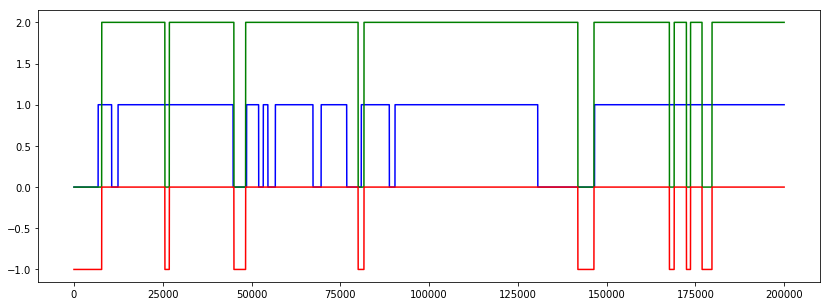

In [124]:
'''
test
green: vad speech detect set
blue: google speech detect set
red: vad nonspeech detect set
'''

# base = np.zeros(200000)
# for i in words_lst:
#     startTime = int(float(i['startTime'].replace('s',''))*1000)
#     endTime = int(float(i['endTime'].replace('s',''))*1000)
#     base[startTime:endTime]=1
    
# speech_base = np.zeros(200000)
# for i in speech_sec_lst:
#     startTime = int(i[0]*1000)
#     endTime = int(i[1]*1000)
#     speech_base[startTime:endTime]=2

# non_speech_base = np.zeros(200000)
# for i in nonspeech_sec_lst:
#     startTime = int(i[0]*1000)
#     endTime = int(i[1]*1000)
#     non_speech_base[startTime:endTime]=-1
    
# plt.figure(figsize=(14, 5))
# plt.plot(base, color='b')
# plt.plot(speech_base, color='g')
# plt.plot(non_speech_base, color='r')

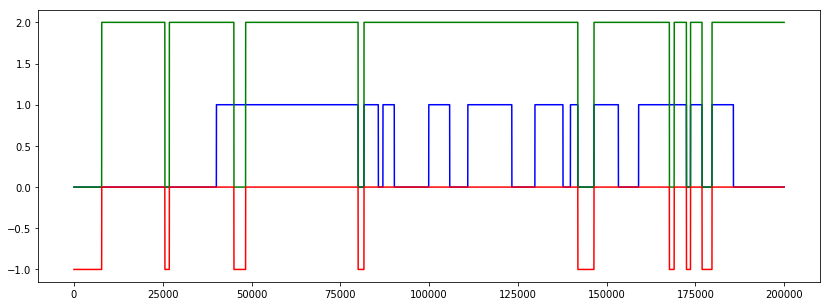

In [119]:
base = np.zeros(200000)
for i in fixed_words_lst:
    startTime = int(float(i['startTime'].replace('s',''))*1000)
    endTime = int(float(i['endTime'].replace('s',''))*1000)
    base[startTime:endTime]=1
    
speech_base = np.zeros(200000)
for i in speech_sec_lst:
    startTime = int(i[0]*1000)
    endTime = int(i[1]*1000)
    speech_base[startTime:endTime]=2

non_speech_base = np.zeros(200000)
for i in nonspeech_sec_lst:
    startTime = int(i[0]*1000)
    endTime = int(i[1]*1000)
    non_speech_base[startTime:endTime]=-1
    
plt.figure(figsize=(14, 5))
plt.plot(base, color='b')
plt.plot(speech_base, color='g')
plt.plot(non_speech_base, color='r')